In [1]:
import pandas as pd
import hvplot.pandas
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
ICE_USDJPY_1D = Path("Resources/ICE_USDJPY_1D.csv")

In [3]:
usdjpy_1D = pd.read_csv(
    ICE_USDJPY_1D,
    index_col="time",
    parse_dates=True,
)
usdjpy_1D = usdjpy_1D.dropna()
print('Shape of data', usdjpy_1D.shape)
usdjpy_1D.head()

Shape of data (11271, 5)


,open,high,low,close,Volume
time,,,,,
1980-09-09,216.50,216.50,216.50,216.50,0
1980-09-10,216.59,216.59,216.59,216.59,0
1980-09-11,214.22,214.22,214.22,214.22,0
1980-09-12,212.70,212.70,212.70,212.70,0
1980-09-15,212.65,212.65,212.65,212.65,0


In [4]:
usdjpy_1D = usdjpy_1D.rename_axis("Date")
usdjpy_1D.head()

,open,high,low,close,Volume
Date,,,,,
1980-09-09,216.50,216.50,216.50,216.50,0
1980-09-10,216.59,216.59,216.59,216.59,0
1980-09-11,214.22,214.22,214.22,214.22,0
1980-09-12,212.70,212.70,212.70,212.70,0
1980-09-15,212.65,212.65,212.65,212.65,0


In [5]:
usdjpy_1D = usdjpy_1D[["close"]]

usdjpy_1D.tail()

,close
Date,
2024-03-11,146.965
2024-03-12,147.610
2024-03-13,147.624
2024-03-14,148.260
2024-03-15,148.243


<Axes: xlabel='Date'>

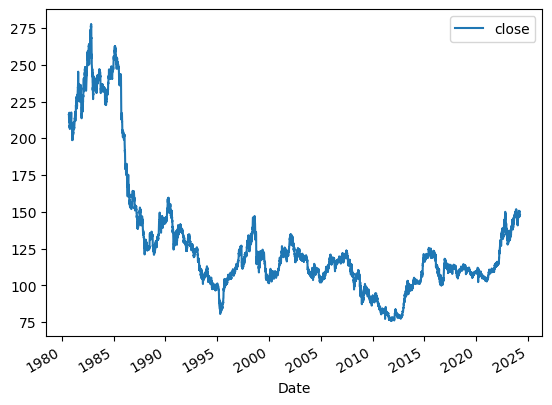

In [6]:
usdjpy_1D.plot()

In [7]:
# Abenomics Implementation in 2013 aimed to stimulate Japan's sluggish economy.

start_date = '2013-01-01'
end_date = '2024-03-14'

# Boolean indexing to select rows within the specified date range
usdjpy_1D2013 = usdjpy_1D[(usdjpy_1D.index >= start_date) & (usdjpy_1D.index <= end_date)]
usdjpy_1D2013

,close
Date,
2013-01-01,86.666
2013-01-02,87.335
2013-01-03,87.216
2013-01-04,88.110
2013-01-07,87.783
...,...
2024-03-08,147.030
2024-03-11,146.965
2024-03-12,147.610


<Axes: xlabel='Date'>

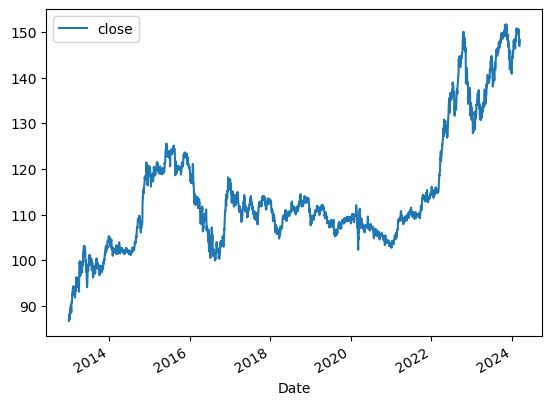

In [8]:
usdjpy_1D2013.plot()

In [9]:
usdjpy_1D2013 = usdjpy_1D2013.asfreq('d', method='ffill')
# 'ffill' is crucial because it will fill in the missing data using the previous avaiable data.
# If not filled, those dates will be dropped and we'll have problems later

usdjpy_1D2013.isnull().sum()

close    0
dtype: int64

In [10]:
# Function that checks for stationarity
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [11]:
check_stationarity(usdjpy_1D2013)

The series is NOT stationary


## Figure out Order for ARIMA Model

In [12]:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(
    usdjpy_1D2013,
    seasonal=True,
    trace=True,
    suppress_warnings=True, 
    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6926.978, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6928.963, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6928.963, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6927.892, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6930.480, Time=1.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.712 seconds


In [13]:
from statsmodels.tsa.arima.model import ARIMA

## Split Data into Training and Testing

In [14]:
print(usdjpy_1D2013.shape)
train = usdjpy_1D2013.iloc[:-90]
test = usdjpy_1D2013.iloc[-90:]
print(train.shape, test.shape)

(4091, 1)
(4001, 1) (90, 1)


## Fit the model to the training data

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [15]:
model = SARIMAX(train, 
                order=(0,1,0),
                seasonal_order = 
               )
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 4001
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3382.822
Date:                Sun, 24 Mar 2024   AIC                           6767.645
Time:                        20:31:11   BIC                           6773.939
Sample:                    01-01-2013   HQIC                          6769.876
                         - 12-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3178      0.003    109.254      0.000       0.312       0.323
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             16961.27
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.63
Prob(H) (two-sided):                  0.04   Kurtosis:                        13.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Forecast

In [18]:
fc, se, conf = model.forecast(90)

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Rate')
plt.plot(fc_series, color = 'orange',label='Predicted Exchange Rate')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('USDJPY Exchange Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: too many values to unpack (expected 3)